# Assignment 6 : Pretrain and Transfer Learning (20 pts)

### Before working on the assignment please read papers as following 
- SUPERVISED CONTRASTIVE LEARNING FOR PRE-TRAINED LANGUAGE MODEL FINE-TUNING
  - link: https://openreview.net/pdf?id=cu7IUiO
- Few-Shot Intent Detection via Contrastive Pre-Training and Fine-Tuning
  - link: https://arxiv.org/abs/2109.06349

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
path = '/content/drive/MyDrive/NLU_Assignments/A6/'
os.chdir(path)

In [31]:
!pip install transformers

## Question 1: Why do we need transfer learning ? (1.5pts)

In [ ]:
#answer1

Answer1:


We ned transfer learning because it can make removing the need for a large set of labelled training data for every new model, improving the efficiency of machine learning development and deployment for multiple models. Moreover, a more generalised approach to machine problem solving, leveraging different algorithms to solve new challenges and models can be trained within simulations instead of real-world environments.

Ref  https://www.seldon.io/transfer-learning

## Question 2: When transfer learning makes sense ? (1.5pts)

In [ ]:
#answer2

Answer2:

Transfer learning makes sence when the training of a system to solve a new task would take a huge amount of resources. The process takes relevant parts of an existing machine learning model and applies it to solve a new but similar problem.


Ref : https://www.seldon.io/transfer-learning

In [32]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import random
from IPython.display import clear_output
from utils import create_supervised_pair, supervised_contrasive_loss, Similarity

# #comment this if you are not using puffer
# os.environ['http_proxy'] = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

## To download data from file directory both text samples and labels

In [33]:
def load_examples(file_path, do_lower_case=True):
    examples = []
    
    with open('{}/seq.in'.format(file_path),'r',encoding="utf-8") as f_text, open('{}/label'.format(file_path),'r',encoding="utf-8") as f_label:
        for text, label in zip(f_text, f_label):
            
            e = Inputexample(text.strip(),label=label.strip())
            examples.append(e)
            
    return examples

## Each sample has a sentence and label format

In [34]:
class Inputexample(object):
    def __init__(self,text_a,label = None):
        self.text = text_a
        self.label = label

### Question3 : Write the code to be able  to control batching data process for the sake of fine-tuning models with combining  cross entropy and supervised contrastive loss in question 5, and only cross entropy in question 4. (7pts)
    
 * assume : we have batch size = 4 but we have 64 classes, so sometime batching process will random sample in a batch, and then it has no any samples come from the same classes like below  
    
    * samples_sentence = ['a','b','c','d'] : assume that one alphabet represent one sentence or one sample
    * labels = [0,1,2,3] ; Therefore, if a batch has unqiue classes equal to batch size, this batch will be skipped due to equation "1yi=yj" of supervised contrastive loss(equation in question 5) that's reason why we need to force like below buttlet. 
    
  * you can see at least one pair that come from the same class.
    
    Therefore, we want dataloader to output like below 
   
    * samples_sentence = ['a','b','c','f'] 
    * labels = [0,1,2,0] ; this batch will pass condition as "1yi=yj" because the label of y[0] = 0, y[3] = 0 in list of labels.

In [36]:
# # create custom dataset class
# # ===  =  Hint =  ===
# # can train on two condition 
# # 1.) trainig training with supervise contrastive loss and cross entropy loss using in question 5.) 
# #    when self.repeated_label == True:
# # 2.) train only cross entropy loss use in question 4.)
# #    when self.repeated_label == False:

class CustomTextDataset(Dataset):
    def __init__(self,labels,text,batch_size,repeated_label:bool=False):
        self.labels = labels
        self.text = text
        self.batch_size = batch_size 
        self.count = 0 
        self.repeated_label = repeated_label

        if self.repeated_label == True:
            self.exist_classes = [] 
            self.ids_ = []
            self.data_length = len(self.labels)
            self.left_batch = False
            self.label_ = None 
            self.num_batch = 0 
            
            
            self.max_count = self.data_length // self.batch_size 
            if self.data_length % self.batch_size !=0:
                self.max_count += 1 


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        if self.repeated_label == True:
            self.count +=1  
            self.exist_classes.append(self.labels[idx])
            self.ids_.append(idx)
            if self.num_batch == self.max_count - 1:
                self.num_batch = +1 
                self.num_batch = 0 
                if self.data_length % self.batch_size !=0: 
                    self.batch_size = self.data_length % self.batch_size
                    self.left_batch = True

            if self.count == self.batch_size:
                unique_labels_keys = list(set(self.exist_classes))
                table = [0] * len(unique_labels_keys)
                unique_labels = dict(zip(unique_labels_keys,table))
                if self.left_batch == True:
                    self.left_batch = False
                    self.batch_size = 4  
                else: 
                    self.num_batch += 1
                for class_key in self.exist_classes:
                    unique_labels[class_key] = +1 
                for index, key  in enumerate(unique_labels):
                    if unique_labels[key] > 1:
                       print("v>1 :",unique_labels[key])
                       break
                    if index == len(unique_labels.keys()) - 1:
                        while True:
                           pos_idx = random.randint(0,self.data_length-1) 
                           if self.labels[pos_idx] in unique_labels.keys():
                               if self.labels[pos_idx] == self.labels[idx]:
                                   pass
                               else:
                                   idx = pos_idx
                                   unique_labels[self.labels[idx]] +=1  
                                   self.exist_classes[-1] = self.labels[idx]
                                   if len(set(self.exist_classes)) ==  len(self.exist_classes):
                                       print(unique_labels)
                                   self.count = 0
                                   self.exist_classes = []
                                   self.ids_ = []
                                   break  
        label = self.labels[idx]
        data = self.text[idx]
        sample = {"Class": label,"Text": data}
        return sample


### What is Few-shot Learning ?
   - few-shot learning is the process of train model on small amount of data in each class to guide model on specific taks, opposed to standard fine-tuning method which requires a large amount of training data for the pretrained model to adapt to the desired task with accuracy.
   
source : https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api

## Define Parameters

In [37]:
N = 5
data = []
labels = []
train_samples = []
train_labels = []
embed_dim = 768
batch_size = 4
lr= 1e-5  # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### The Aim of these training is to fine tuning on few shot setting on text classification task

Path example of train, validation and test 

In [38]:
path_5shot = f'./HWU64/train_5/'
path_test = f'./HWU64/test/'
path_valid = f'./HWU64/valid/'

### Dataset Structure
![image.png](attachment:292797f7-abc3-4e99-93ef-6c2c02ef13a5.png)

In [39]:
 #!unzip HWU64.zip

Archive:  HWU64.zip
replace HWU64/valid/label? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HWU64/valid/seq.in? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HWU64/train_5/label? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HWU64/train_5/seq.in? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HWU64/train_10/label? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HWU64/train_10/seq.in? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HWU64/train/seq.in? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HWU64/train/label? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HWU64/test/label? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HWU64/test/seq.in? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [40]:

# https://downgit.github.io/#/home?url=https:%2F%2Fgithub.com%2Fjianguoz%2FFew-Shot-Intent-Detection%2Ftree%2Fmain%2FDatasets%2FHWU64

# downloading training samples 
train_samples = load_examples(path_5shot)

# write code here : for downloading validation samples
val_samples = load_examples(path_valid)

#write code here : for downloading test samples
test_samples = load_examples(path_test)



data_val = []
labels_val = []
data_test = []
labels_test = []



# preprocess for training 
for i in range(len(train_samples)):
    data.append(train_samples[i].text)
    labels.append(train_samples[i].label)
    
# write code here :preprocess validation samples
for i in range(len(val_samples)):
    data_val.append(val_samples[i].text)
    labels_val.append(val_samples[i].label)

# write code here : preprocess test samples
for i in range(len(test_samples)):
    data_test.append(test_samples[i].text)
    labels_test.append(test_samples[i].label)

# dataloader for training 
train_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=True)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)


# write code here : dataloader for validation
val_data = CustomTextDataset(labels_val,data_val,batch_size=batch_size,repeated_label=True)
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=True)



# write code here : dataloader for test
test_data = CustomTextDataset(labels_test,data_test,batch_size=batch_size,repeated_label=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)



# got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels)))

# get text label of uniqure classes
unique_label = np.unique(np.array(labels))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

# Download tokenizer that use to tokenize sentence into words by using Pretrain from roberta-base
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

## Download Pretrain Model

In [41]:
# download config of Roberta config 
config = RobertaConfig.from_pretrained("roberta-base",output_hidden_states=True)

#chnage modifying the number of classes
config.num_labels = num_class
# Download pretrain models weight 
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
# change from binary classification to muli-classification and loss automatically change to cross entropy loss
model.num_labels = config.num_labels
# change the output of last layer to num_class that we want to predict
model.classifier.out_proj = nn.Linear(in_features=embed_dim,out_features=num_class)
# move to model to device that we set
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [42]:
# Using adam optimizer 
optimizer= AdamW(model.parameters(), lr=lr)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## Question3: write function to freeze model (3pts)


In [43]:
def freeze_layers(model,freeze_layers_count:int):

        """
        model : model object that we create 
        freeze_layers_count : the number of layers to freeze 
        """
        # write the code here
        #freeze_layers_count = sum(p.numel() for p in model.parameters() if p.requires_grad = False)
        for params in model.roberta.embeddings.parameters():
          params.requires_grad = False
          # print("Embeddings: ", params.requires_grad) 
        for i, layer in enumerate(model.roberta.encoder.layer):
          if i < freeze_layers_count:
            for params in layer.parameters():
                params.requires_grad = False 
    
        #return freeze_layers_count
        return model

In [44]:
model= freeze_layers(model, 10)

In [45]:
for params in model.roberta.encoder.layer.parameters():
    print(params.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True


## Question4: Training on text classification task on CrossEntropy loss (3.5 pts)
- Using API of hugging face of RobertaForSequenceClassification
  - source : https://huggingface.co/transformers/v3.0.2/model_doc/roberta.html#robertaforsequenceclassification
- report performance of models (test acc) with differrent experiement of unfreezing of bottom layers and compare the result of each
    - 4.1. freeze weight from pretrain model all layer except classifier 
    - ![image.png](attachment:47aed217-d5e9-4b09-a916-8bbe57f2fbb8.png)
    
   
    - 4.2. freeze all from top embeddings to encoder layers (9)
      - embeddings
        - ![image.png](attachment:2a69ebe1-6893-45ca-b7ea-38f9715b8c9a.png)
      - layer 9
        - ![image.png](attachment:ef8674dc-7743-40d4-bde4-21a3819e62fb.png)
    - 4.3 add code to collect loss and accuracy of training history  of (4.1 and 4.2)
    - 4.4 add the code in below in training loop collect validation loss and accuracy history of (4.1 and 4.2)
    
- hint: for this training on Cross entropy loss no need to control the outcome of class in each batch using code below to train model base on how many layers that you freeze  
  - to see whole architecture look like you can use mode.eval() 

In [46]:
# this code training models on Cross entropy loss

train_losses = []
#valid_losses = []
best_train_loss = float('inf')
total_acc_train = []
acc_train = 0.0
n_correct = 0.0
n_wrong = 0.0

for epoch in range(30):  # loop over the dataset multiple times
#for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    
    for (idx, batch) in enumerate(train_loader):
        sentence = batch["Text"]
        inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")
        
        # move parameter to device
        inputs = {k:v.to(device) for k,v in inputs.items()}

        # map string labels to class idex
        labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

        #print("show out: ",np.unique(labels, return_counts=True))
        # convert list to tensor
        labels = torch.tensor(labels).unsqueeze(0)
        labels = labels.to(device)


        #(batch_size, seq_len)
        #print(inputs["input_ids"].shape)

         # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(**inputs,labels=labels)
        # you can check 
        loss, logits = outputs[:2]
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        #acc = (outputs.argmax(dim=1) == labels).sum().item()
        #acc = (np.argmax(logits) == labels).sum().detach().cpu().numpy()



        pred_class = torch.argmax(logits)
        if pred_class in labels:
          n_correct += 1
        else:
          n_wrong += 1

        acc_train = (n_correct * 1.0) / (n_correct + n_wrong)
        total_acc_train.append(acc_train)
        #print(total_acc_train)
       
        # write code here 
        # to save model eg. model.pth look at pytorch document how to save model
        
        if loss.item() < best_train_loss:
            best_train_loss = loss.item()
            torch.save(model.state_dict(), 'best_model.pt')
    
        
        print(f'[{epoch + 1}, {idx}] loss: {loss.item()}')
        print(running_loss)  
        clear_output(wait=True)

[30, 79] loss: 0.15687458217144012
0.0


In [47]:
#next(iter(train_loader))

In [49]:
# this code training models on Cross entropy loss

valid_losses = []
#valid_losses = []
best_valid_loss = float('inf')

total_acc_valid = []
acc_valid = 0.0
n_correct = 0.0
n_wrong = 0.0

model.eval()

for epoch in range(30):  # loop over the dataset multiple times
#for epoch in range(2):# loop over the dataset multiple times
    
    running_loss = 0.0
    with torch.no_grad():
        for (idx, batch) in enumerate(val_loader):
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")

            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            #print("show out: ",np.unique(labels, return_counts=True))
            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)


            #(batch_size, seq_len)
            #print(inputs["input_ids"].shape)

             # zero the parameter gradients
            # optimizer.zero_grad()

            outputs = model(**inputs,labels=labels)
            # you can check 
            loss, logits = outputs[:2]

            # loss.backward()
            # optimizer.step()

            valid_losses.append(loss.item())
            
            pred_class = torch.argmax(logits)
            if pred_class in labels:
              n_correct += 1
            else:
              n_wrong += 1
            acc_valid = (n_correct * 1.0) / (n_correct + n_wrong)
            total_acc_valid.append(acc_valid)



            # write code here 
            # to save model eg. model.pth look at pytorch document how to save model

            if loss.item() < best_valid_loss:
                best_valid_loss = loss.item()
                torch.save(model.state_dict(), 'best_model_valid.pt')


            print(f'[{epoch + 1}, {idx}] loss: {loss.item()}')
            print(running_loss)  
            clear_output(wait=True)

[30, 268] loss: 1.429790735244751
0.0


   - 4.5 write code to plot both loss and accuracy for training and validation repectively.
   - 4.6 write test function to get test accuracy for (4.1,4.2) 

Text(0, 0.5, 'Accuracy')

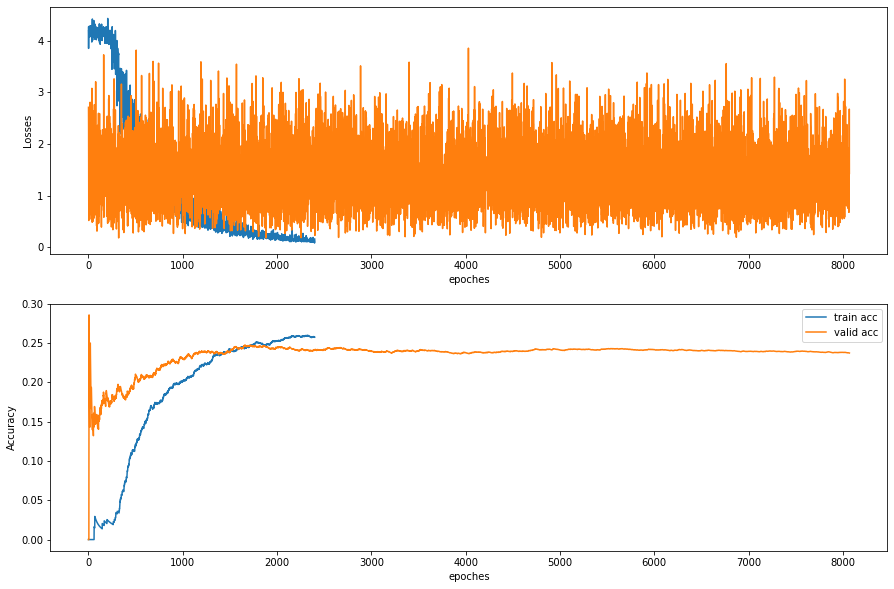

In [50]:
# write code here for 4.5
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(train_losses, label = 'train loss')
ax1.plot(valid_losses, label = 'valid loss')
ax2.plot(total_acc_train, label = 'train acc')
ax2.plot(total_acc_valid, label = 'valid acc')
plt.legend()
ax1.set_xlabel('epoches')
ax1.set_ylabel('Losses')
ax2.set_xlabel('epoches')
ax2.set_ylabel('Accuracy')


# Question 5: Training on text classification task  on combine two losses Cross Entropy and Supervised Contrastive. (3.5 pts)

- Cross Entropy loss
$$
\mathcal{L}_\text{CE} =-\frac{1}{m} \sum_{i=1}^{m} yi \cdot log(\hat{yi})
$$

- Supervised Contrastive learning loss
$$
\mathcal{L}_\text{S_cl} = -\frac{1}{T}\sum_{i=1}^{N}\sum_{j=1}^{N} \boldsymbol{1_{yi=yj}}\enspace log \frac{e^{sim(hi,hj) / \tau}}{\sum_{n=1}^{N} e^{sim(hi,hn) / \tau}}
$$
     * detail 
       * ui ~ sentence i 
       * hi ~ BERT(ui) in our case using Roberta as a encoder
       * hi : (batch_size,sequence_len,embed_size)
       * hi is the output of model which is last hidden layers before classifier head in the model architecture
       * 1yi=yj ~ we select only the sample that come from the same class to compute in each i and j
       * T ~ the number of pairs that come from the same classes
       * $\tau$ ~ temperature parameter
       * Sim(x1,x2) : cosine similarity [-1, 1]
       - $\lambda'$ is just weighted of cross entropy loss 
       * Sim function is the cosine similarity 
       * N ~ the number of samples in a batch
$$
sim(A,B) = \cos{(\theta)} = \frac{A\cdot B}{|\!|A|\!||\!|B|\!|}
$$


- Loss total
$$
  \mathcal{L}_\text{total} = \mathcal{L}_\text{s_cl} + \lambda ' \mathcal{L}_{CE}
$$

* you can get cross entropy loss like below 
    * outputs = model(input_ids, labels=labels)
    * loss, logits = outputs[:2]
    * loss : this is cross entropy loss
      
- hint : for this question you will utilize the function CustomTextDataset to force dataloader to have at least one pair that come from the same class
     * eg. batch_size = 4 
     * the labels in a batch should be like [ 0, 21, 43, 0]  
     
5. training this model in the code below on loss_total by do experiment the same as question 4.1, 4.2, 4.3, 4.4, 4.5, 4.6

In [51]:
def freeze_layers(model,freeze_layers_count:int):

        """
        model : model object that we create 
        freeze_layers_count : the number of layers to freeze 
        """
        # write the code here
        #freeze_layers_count = sum(p.numel() for p in model.parameters() if p.requires_grad = False)
        for params in model.roberta.embeddings.parameters():
          params.requires_grad = False
          # print("Embeddings: ", params.requires_grad) 
        for i, layer in enumerate(model.roberta.encoder.layer):
          if i < freeze_layers_count:
            for params in layer.parameters():
                params.requires_grad = False 
    
        #return freeze_layers_count
        return model

In [52]:
model_freezed = freeze_layers(model, 10)

In [53]:
for params in model_freezed.roberta.encoder.layer.parameters():
    print(params.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True


In [57]:
train_losses_ = []
best_train_loss_ = float('inf')
total_acc_train_ = []
acc_train_ = 0.0
n_correct_ = 0.0
n_wrong_ = 0.0


for epoch in range(30):  # loop over the dataset multiple times
    
    running_loss = 0.0
    
    
    for (idx, batch) in enumerate(train_loader):
        sentence = batch["Text"]
        inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")
        inputs = {k:v.to(device) for k,v in inputs.items()}

        # map string labels to class idex
        labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

        
        # convert list to tensor
        labels = torch.tensor(labels).unsqueeze(0)
        labels = labels.to(device)


        #(batch_size, seq_len)
        #print(inputs["input_ids"].shape)

          # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(**inputs,labels=labels,output_hidden_states=True)     
        
        hidden_states = outputs.hidden_states
        
        last_hidden_states = hidden_states[12]
        
        # https://stackoverflow.com/questions/63040954/how-to-extract-and-use-bert-encodings-of-sentences-for-text-similarity-among-sen 
        # (batch_size,seq_len,embed_dim)
        h = last_hidden_states[:,0,:]
        
        # create pair samples
        T, h_i, h_j, idx_yij = create_supervised_pair(h,batch['Class'],debug=False)
        
        if h_i is None:
            print("skip this batch")
            skip_time +=1
            continue
                
        # supervised contrastive loss 
        loss_s_cl = supervised_contrasive_loss(h_i, h_j, h, T,temp=temp,idx_yij=idx_yij,debug=False)
        
        # cross entropy loss
        loss_classify, logits = outputs[:2]
        
        # loss total
        loss = loss_s_cl + (lamda * loss_classify)
        
        loss.backward()
        optimizer.step()

        train_losses_.append(loss.item())
        #acc = (outputs.argmax(dim=1) == labels).sum().item()
        #acc = (np.argmax(logits) == labels).sum().detach().cpu().numpy()



        pred_class_ = torch.argmax(logits)
        if pred_class_ in labels:
          n_correct_ += 1
        else:
          n_wrong_ += 1

        acc_train_ = (n_correct_ * 1.0) / (n_correct_ + n_wrong_)
        total_acc_train_.append(acc_train_)

        if loss.item() < best_train_loss_:
            best_train_loss_ = loss.item()
            torch.save(model.state_dict(), 'best_model_combine.pt')
        
        
        print(f'[{epoch + 1}, {idx}] loss_total: {loss.item()}, loss_s_cl:{loss_s_cl.item()}, loss_classify:{lamda * loss_classify.item()}')
        
        clear_output(wait=True)        

RuntimeError: ignored

In [58]:
val_losses_ = []
best_val_loss_ = float('inf')
total_acc_val_ = []
acc_val_ = 0.0
n_correct_ = 0.0
n_wrong_ = 0.0

model.eval()


for epoch in range(30):  # loop over the dataset multiple times
    
    running_loss = 0.0
    with torch.no_grad():
    
      for (idx, batch) in enumerate(val_loader):
          sentence = batch["Text"]
          inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")
          inputs = {k:v.to(device) for k,v in inputs.items()}

          # map string labels to class idex
          labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

          
          # convert list to tensor
          labels = torch.tensor(labels).unsqueeze(0)
          labels = labels.to(device)


          #(batch_size, seq_len)
          #print(inputs["input_ids"].shape)

          # zero the parameter gradients
          #optimizer.zero_grad()

          outputs = model(**inputs,labels=labels,output_hidden_states=True)     
          
          hidden_states = outputs.hidden_states
          
          last_hidden_states = hidden_states[12]
          
          # https://stackoverflow.com/questions/63040954/how-to-extract-and-use-bert-encodings-of-sentences-for-text-similarity-among-sen 
          # (batch_size,seq_len,embed_dim)
          h = last_hidden_states[:,0,:]
          
          # create pair samples
          T, h_i, h_j, idx_yij = create_supervised_pair(h,batch['Class'],debug=False)
          
          if h_i is None:
              print("skip this batch")
              skip_time +=1
              continue
                
          # supervised contrastive loss 
          loss_s_cl = supervised_contrasive_loss(h_i, h_j, h, T,temp=temp,idx_yij=idx_yij,debug=False)
          
          # cross entropy loss
          loss_classify, logits = outputs[:2]
          
          # loss total
          loss = loss_s_cl + (lamda * loss_classify)
          
          # loss.backward()
          # optimizer.step()

          val_losses_.append(loss.item())
          #acc = (outputs.argmax(dim=1) == labels).sum().item()
          #acc = (np.argmax(logits) == labels).sum().detach().cpu().numpy()



          pred_class_ = torch.argmax(logits)
          if pred_class_ in labels:
            n_correct_ += 1
          else:
            n_wrong_ += 1

          acc_val_ = (n_correct_ * 1.0) / (n_correct_ + n_wrong_)
          total_acc_val_.append(acc_val_)
      
          if loss.item() < best_val_loss_:
              best_val_loss_ = loss.item()
              torch.save(model.state_dict(), 'best_model_combine_valid.pt')
        
          
          print(f'[{epoch + 1}, {idx}] loss_total: {loss.item()}, loss_s_cl:{loss_s_cl.item()}, loss_classify:{lamda * loss_classify.item()}')
        
          clear_output(wait=True) 

skip this batch


RuntimeError: ignored

NameError: ignored

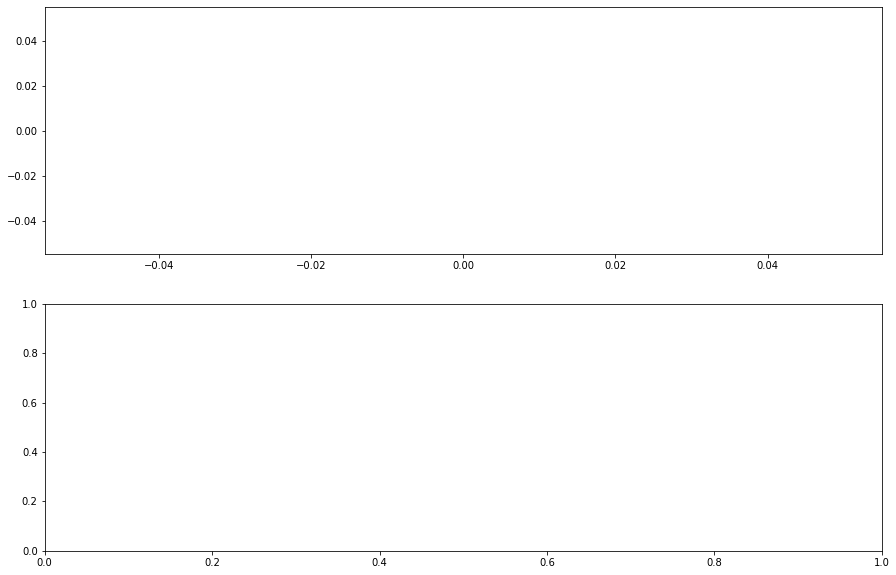

In [59]:
# write code here for 4.5
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(train_losses_, label = 'train loss')
ax1.plot(valid_losses_, label = 'valid loss')
ax2.plot(total_acc_train_, label = 'train acc')
ax2.plot(total_acc_valid_, label = 'valid acc')
plt.legend()
ax1.set_xlabel('epoches')
ax1.set_ylabel('Losses')
ax2.set_xlabel('epoches')
ax2.set_ylabel('Accuracy')

I got CUDA error. I also tried on puffer with various cuda but it still get that error. Moreover, eventhough i tried on colab with GPU and CUDA, it still get CUDA error.

